In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt                                        # for plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical


# This line is simply to avoid syntax errors in VSCode
train_set_x_flat, train_set_y, test_set_x_flat, test_set_y = None, None, None, None

print("Read shared variables created in network.ipynb\n")
%store -r train_set_x_flat
%store -r train_set_y
%store -r test_set_x_flat
%store -r test_set_y

print(train_set_x_flat.shape)
print(train_set_y.shape)
print(test_set_x_flat.shape)
print(test_set_y.shape)

2022-08-26 13:35:35.108369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 13:35:35.108397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Read shared variables created in network.ipynb

(209, 12288)
(209,)
(50, 12288)
(50,)


In [2]:
# normalize pixel values to be in interval [0, 1]
train_set_x_flat_n = train_set_x_flat / 255.0
test_set_x_flat_n = test_set_x_flat / 255.0

print("without normalization:")
print(train_set_x_flat[0])
print("\nwith normalization:")
print(train_set_x_flat_n[0])

without normalization:
[17 31 56 ...  0  0  0]

with normalization:
[0.06666667 0.12156863 0.21960784 ... 0.         0.         0.        ]


In [3]:
model = tf.keras.Sequential()
model.add(layers.Flatten())
# shallow layer ↓
model.add(layers.Dense(40, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="sigmoid"))
# output layer ↓ (since it's binary classification and there's one 1 output layer / the y_set has only one value, I need to use sigmoid)
model.add(layers.Dense(1, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="sigmoid"))

# learning_rate that work poorly: 0.9, 0.1
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

input_shape = train_set_x_flat_n.shape
model.build(input_shape)

# do gradient descent
results = model.fit(train_set_x_flat_n, train_set_y, validation_data = (test_set_x_flat_n, test_set_y), batch_size = 16, epochs=200, verbose=1)


2022-08-26 13:35:39.444617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 13:35:39.444658: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 13:35:39.444693: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nPC): /proc/driver/nvidia/version does not exist


Epoch 1/200
14/14 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 2/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 5/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 6/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.6555 - val_loss: 0.0000e+00 - val_accuracy: 0.3400
Epoch 7/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.6

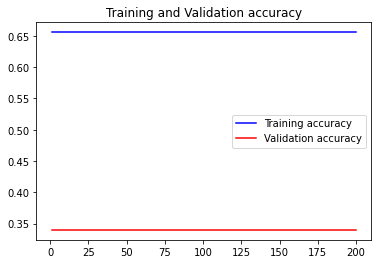

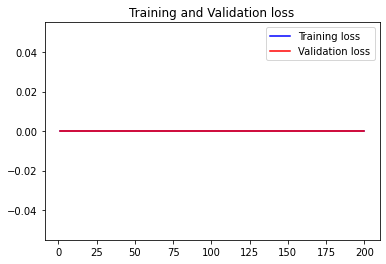

2/2 [==============================] - 0s 4ms/step


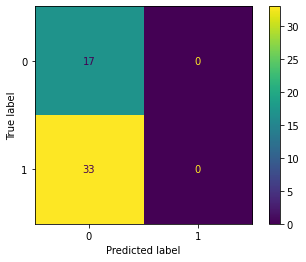

In [4]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

num_classes = 2
# one-hot-encoding y set
y_test_multi_class = to_categorical(test_set_y, num_classes)
y_test_prediction = model.predict(test_set_x_flat_n)

tf.compat.v1.disable_eager_execution() # this avoids a warning message, more info in https://stackoverflow.com/questions/69136518/tensorflow-2-getting-warningtensorflowx-out-of-the-last-x-calls-to-function

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(y_test_multi_class.argmax(axis=1), y_test_prediction.argmax(axis=1))